In [2]:
from functools import partial

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
import statsmodels.api as sm
import xarray as xr
from jax import jit, lax, random, vmap
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [ ]:
data_path = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/online_game_ate.csv"

raw_df = pl.read_csv(data_path)



columns_to_keep = [
    "Guild Membership", "Side-quest Engagement",
         "Won Items", "In-game Purchases",]

df = raw_df[columns_to_keep] 

df.head()

Guild Membership,Side-quest Engagement,Won Items,In-game Purchases
i64,i64,i64,f64
0,1,1,1030.29
0,1,0,2453.34
0,1,1,3761.4
1,1,1,1007.84
0,1,0,4153.94


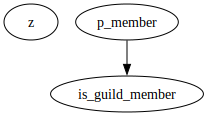

In [12]:
def model():
    z = numpyro.sample("z", dist.Normal(0.0, 1.0))

    p_member = numpyro.sample("p_member", dist.Beta(2, 5))

    is_guild_member = numpyro.sample("is_guild_member", dist.Bernoulli(p_member))


numpyro.render_model(model)

In [ ]:
# def model(params, device=device):    #A
#     z_dist = Normal(    #B
#         tensor(0.0, device=device),    #B
#         tensor(1.0, device=device))    #B
#     z = sample("Z", z_dist)    #B
#     member_dist = Bernoulli(params['ρ_member'])    #C
#     is_guild_member = sample("Guild Membership", member_dist)    #C
#     engagement_input = stack((is_guild_member, z)).to(device)   #D
#     ρ_engagement = confounders_2_engagement(engagement_input)    #D
#     engage_dist = Bernoulli(ρ_engagement)
#     is_highly_engaged = sample("Side-quest Engagement", engage_dist)    #E
#     p_won = (    #F
#         params['ρ_won_engaged'] * is_highly_engaged +    #F
#         params['ρ_won_not_engaged'] * (1 - is_highly_engaged)    #F
#     )    #F
#     won_items = sample("Won Items", Bernoulli(p_won))    #F
#     purchase_input = stack((won_items, is_guild_member, z)).to(device)    #G
#     μ_purchases, σ_purchases = purchases_network(purchase_input)    #G
#     purchase_dist = Normal(μ_purchases, σ_purchases)    #H
#     in_game_purchases = sample("In-game Purchases", purchase_dist)